In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

sent: <object object at 0x12a426a90>


In [2]:
SYM = 'IWF'
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_iwf.pkl' # Russell 1000
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Generating derived columns...
(6281, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2000-05-26,59.930088,59.966039,59.930088,59.966039,59.930088,4.093179,0.999400,1.018997,1.017197
2000-05-30,61.068565,61.068565,60.960713,60.960713,61.068565,4.111997,1.001769,1.031005,1.016876
2000-05-31,62.961971,62.961971,62.099150,62.099150,62.961971,4.142531,1.013894,1.009516,0.999429
2000-06-01,63.561142,63.800814,62.926010,62.926010,63.561142,4.152002,1.010093,1.036388,1.031863
2000-06-02,65.874023,65.874023,65.370711,65.586416,65.874023,4.187744,1.004385,0.994178,0.991085
2000-06-05,65.490501,65.957863,65.286780,65.286780,65.490501,4.181905,1.003120,1.002562,0.999817
2000-06-06,65.658287,65.706222,65.478533,65.478533,65.658287,4.184464,1.002745,0.996167,0.985946
2000-06-07,65.406601,65.406601,64.735518,64.735518,65.406601,4.180623,1.010367,0.993771,1.004031
2000-06-08,64.999199,65.682266,64.999199,65.670282,64.999199,4.174375,0.989781,1.003503,1.010693


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2000-05-26     59.966039
2000-05-30     61.068565
2000-05-31     62.961971
2000-06-01     63.800814
2000-06-02     65.874023
                 ...    
2025-05-12    390.910004
2025-05-13    398.089996
2025-05-14    400.399994
2025-05-15    401.000000
2025-05-16    401.524994
Name: high, Length: 6278, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2009-01-02', utc=True)  # first day of legit open/close values
SIM_START

Timestamp('2009-01-02 00:00:00+0000', tz='UTC')

In [7]:
len(df.index >= str(SIM_START.date()))

6281

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

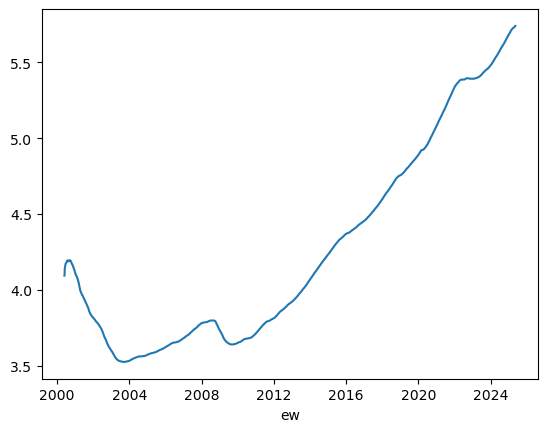

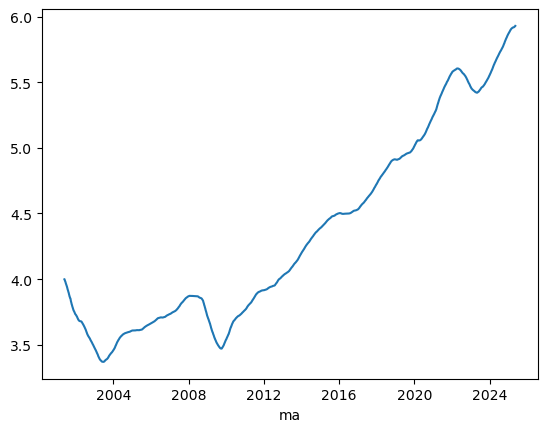

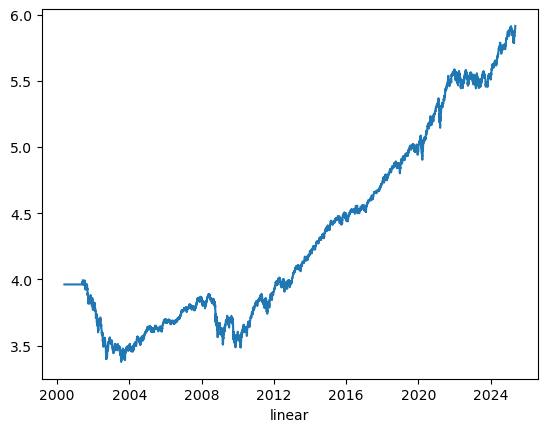

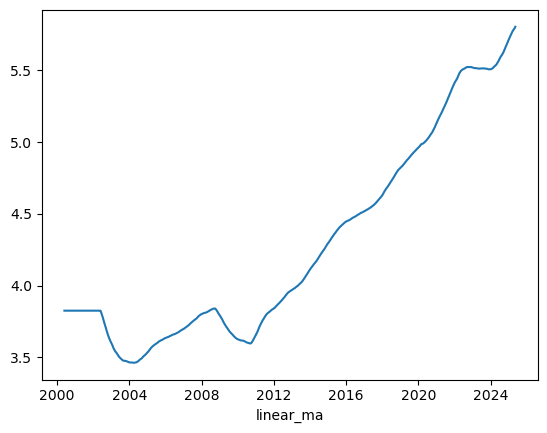

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    ###
    df = df[df.trend_factor.notnull()]
    ###
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= str(SIM_START.date()), :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[str(SIM_START.date()), 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(69.8389140548989,
 {'time_param': 9,
  'method': 'ew',
  't': 0.9630287040151951,
  'k': 9.988366124057293,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

Do nothing res: 12.684645933537814
Round 1: 69.75036096410912
New best: 69.75036096410912
{'time_param': 9, 'method': 'ew', 't': 0.9630287040151951, 'k': 9.988366124057293, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


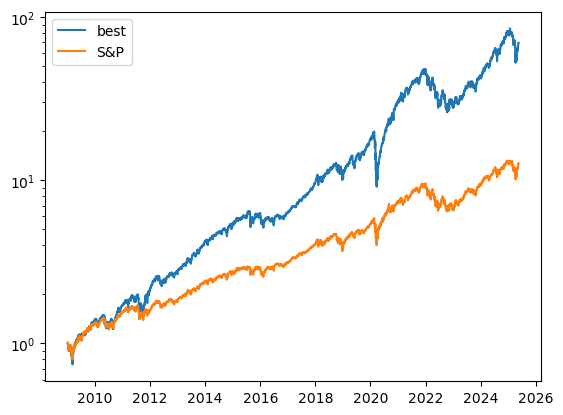

Round 2: 1.2892478749495473
Round 3: 38.232478196106506
Round 4: 1.0030841025982447
Round 5: 1.0984269841392862
Round 6: 1.0260199791766684
Round 7: 5.316446071893542
Round 8: 25.505579630367457
Round 9: 1.367021633555836
Round 10: 47.595486344204225
Round 11: 3.2441396817712587
Round 12: 6.775920753655555
Round 13: 6.857871521828847
Round 14: 10.506957672766886
Round 15: 7.302505905161691
Round 16: 50.22150880812772
Round 17: 5.913354291029863
Round 18: 19.916723874512158
Round 19: 18.651910712234113
Round 20: 13.756698116143625
Round 21: 18.43206554542463
Round 22: 16.503179685559324
Round 23: 1.3894559476678652
Round 24: 9.105028851753852
Round 25: 10.26389508103268
Round 26: 1.0771268928087443
Round 27: 1.4491723370502378
Round 28: 3.0741313670620323
Round 29: 40.05882612229121
Round 30: 39.105814174460896
Round 31: 5.239113887850184
Round 32: 1.80583894060339
Round 33: 38.16769083983855
Round 34: 48.27688567697355
Round 35: 12.390355075241528
Round 36: 1.3877340898555013
Round 37:

In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

Factor: 1.0625
Do nothing res: 12.684645933537814
Round 1: 51.27772879374806
Round 2: 51.26974659396435
Round 3: 10.254516154516239
Round 4: 8.279605364761645
Round 5: 51.27524820535577
Round 6: 20.305930255670997
Round 7: 2.988459059681159
Round 8: 51.27276236182547
Round 9: 33.68583649804099
Round 10: 37.42852834440106
Round 11: 47.67741949771006
Round 12: 51.27161612829468
Round 13: 37.325361469509446
Round 14: 35.99325703785006
Round 15: 51.27772879374806
Round 16: 60.25821968073405
Round 17: 26.394273043274424
Round 18: 60.36500959831689
Round 19: 54.488138620699836
Round 20: 51.26412526859122
Round 21: 19.690705680407227
Round 22: 51.27772879374806
Round 23: 39.92283428563447
Round 24: 54.612625750643176
Round 25: 58.54590595700845

Factor: 1.03125
Do nothing res: 12.684645933537814
Round 1: 51.27772879374806
Round 2: 51.27772879374806
Round 3: 50.50578500719064
Round 4: 3.7599822070480826
Round 5: 51.27667290273258
Round 6: 7.91714681473797
Round 7: 3.8977143446417974
Round 8: 1

In [20]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

0.00013307661315031805

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.9815286624203822

In [24]:
params_out

{'time_param': 9,
 'method': 'ew',
 't': 0.9630287040151951,
 'k': 9.988366124057293,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/dsp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)
/Users/dsp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: overflow encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


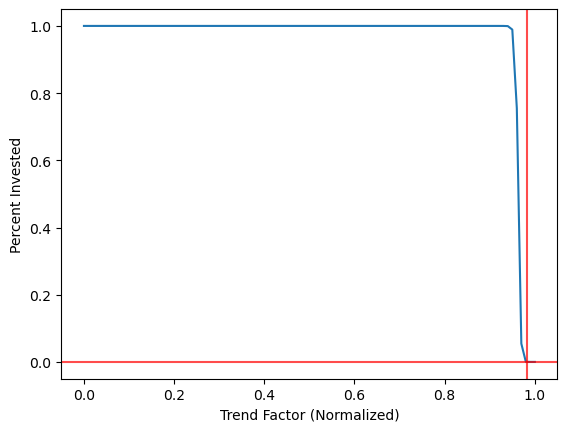

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

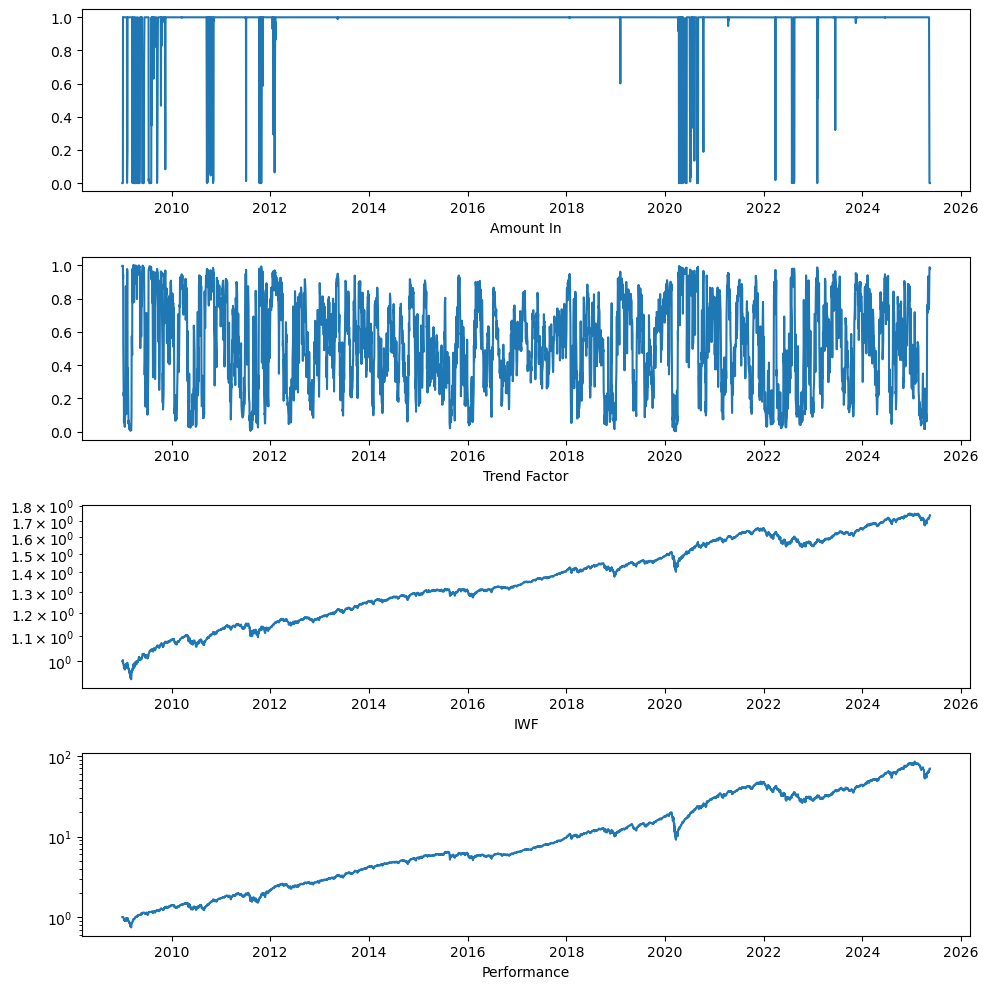

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('IWF')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

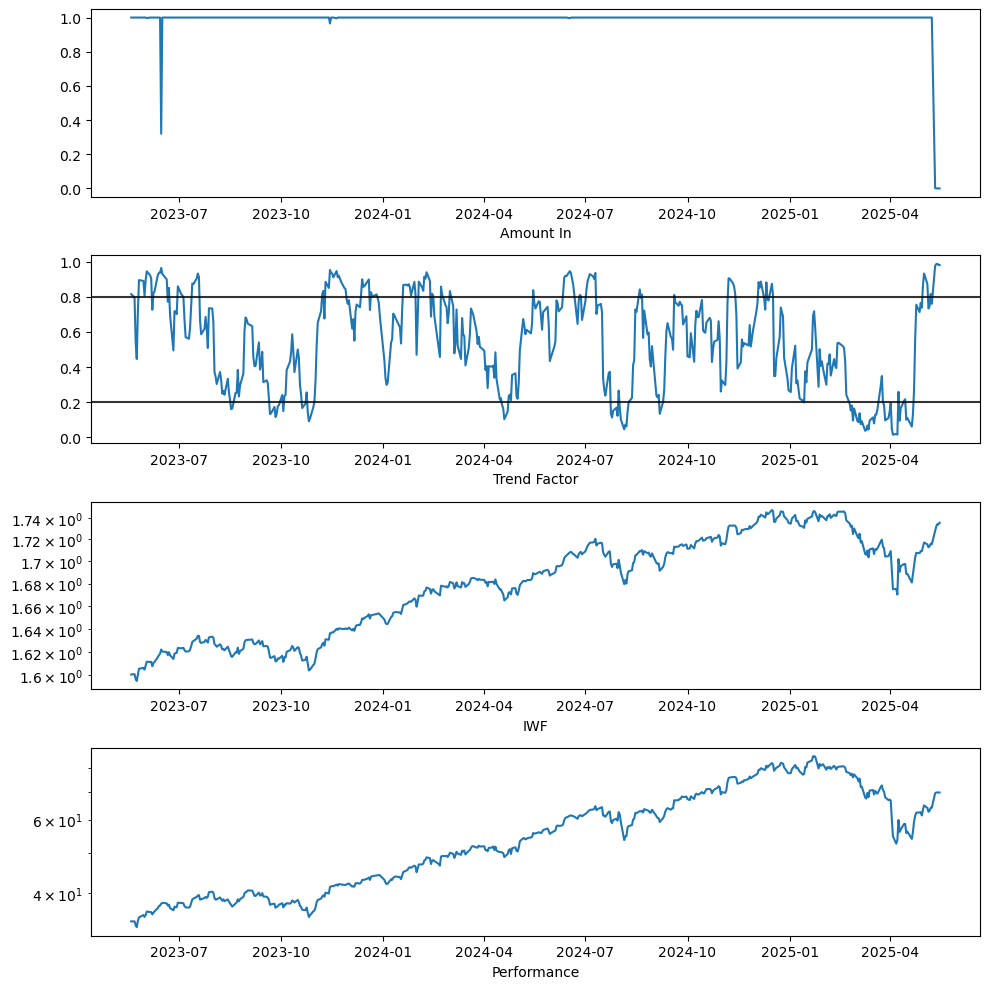

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')
plt.axhline(y=0.2, color='k', alpha=0.8)
plt.axhline(y=0.8, color='k', alpha=0.8)

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('IWF')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.0001

In [30]:
# n days
n = (df.index >= str(SIM_START.date())).sum()
# n years
t = n / 250
# amt at start
p = df.loc[str(SIM_START.date()), 'value']
amt = df.iloc[-1].value
p, t, amt

(31.642980575561523, 16.476, 401.3800048828125)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.2938765494620048

In [32]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['rus'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.119537057595255, 0.0336], 'dia': [1.1600289355392615, 0.9963], 'nas': [1.2368004505358, 1.0], 'rus': [1.2938765494620048, 0.0001], 'jpxn': [1.067609313829114, 1.0], 'ktec': [1.6317632641049638, 0.0], 'eem': [1.210138091847281, 1.0], 'nfty': [1.262556097182899, 1.0], 'gdx': [1.4408631165331298, 0.0]}


In [33]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(69.75036096410912,
 {'time_param': 9,
  'method': 'ew',
  't': 0.9630287040151951,
  'k': 9.988366124057293,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})